# Significance

In [1]:
import xarray as xr
from climpred.tutorial import load_dataset
from climpred.prediction import compute_hindcast, compute_perfect_model
from climpred.bootstrap import bootstrap_hindcast, bootstrap_perfect_model
import matplotlib.pyplot as plt

In [145]:
v='SST'
hind = load_dataset('CESM-DP-SST')[v]
hind.lead.attrs['units']='years'

In [146]:
hist = load_dataset('CESM-LE')[v]
hist = hist-hist.mean()

In [147]:
obs = load_dataset('ERSST')[v]
obs = obs-obs.mean()

In [148]:
# adjust times
hind['init'] = xr.cftime_range(start=str(hind.init.min().astype('int').values),periods=hind.init.size,freq='YS')
hist['time'] = xr.cftime_range(start=str(hist.time.min().astype('int').values),periods=hist.time.size,freq='YS')
obs['time'] = xr.cftime_range(start=str(obs.time.min().astype('int').values),periods=obs.time.size,freq='YS')

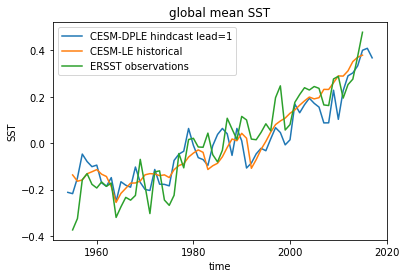

In [149]:
hind.sel(lead=1).mean('member').plot(label='CESM-DPLE hindcast lead=1')
hist.mean('member').plot(label='CESM-LE historical')
obs.plot(label='ERSST observations')
plt.legend()
plt.title(f'global mean {v}')
plt.show()

In [150]:
order=2
hind = climpred.stats.rm_poly(hind, dim='init', order=order)
hist = climpred.stats.rm_poly(hist, dim='time', order=order)
obs = climpred.stats.rm_poly(obs, dim='time', order=order)
hind.lead.attrs['units']='years'

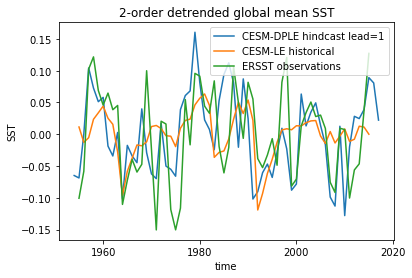

In [151]:
hind.sel(lead=1).mean('member').plot(label='CESM-DPLE hindcast lead=1')
hist.mean('member').plot(label='CESM-LE historical')
obs.plot(label='ERSST observations')
plt.legend()
plt.title(f'{order}-order detrended global mean {v}')
plt.show()

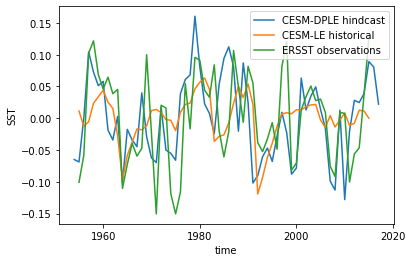

In [152]:
hind.isel(lead=0).mean('member').plot(label='CESM-DPLE hindcast')
hist.mean('member').plot(label='CESM-LE historical')
obs.plot(label='ERSST observations')
plt.legend()

In [122]:
acc = compute_hindcast(hind, obs, metric='pearson_r', comparison='e2r')

In [123]:
acc_p_value = compute_hindcast(hind, obs, metric='pearson_r_p_value', comparison='e2r')

In [2]:
sig = .05

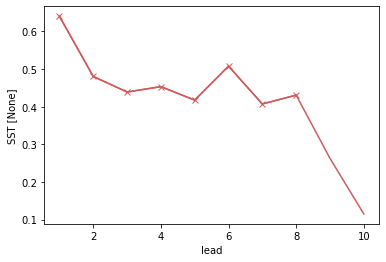

In [154]:
acc.plot(c='indianred')
acc.where(acc_p_value <= sig).plot(marker='x',c='indianred')

In [126]:
bootstrapped_acc = bootstrap_hindcast(hind, hist, obs, metric='pearson_r', comparison='e2r', bootstrap=100)

/Users/aaron.spring/anaconda3/envs/climpred-dev/lib/python3.6/site-packages/xarray/core/dataarray.py:669: FutureWarning: elementwise comparison failed; returning scalar instead, but in the future will perform elementwise comparison
  return key in self.data


In [127]:
bootstrapped_acc.coords

Coordinates:
  * lead     (lead) int64 1 2 3 4 5 6 7 8 9 10
  * kind     (kind) object 'init' 'pers' 'uninit'
  * results  (results) <U7 'skill' 'p' 'low_ci' 'high_ci'

In [128]:
init_skill = bootstrapped_acc.sel(results='skill',kind='init')
init_better_than_uninit = init_skill.where(bootstrapped_acc.sel(results='p',kind='uninit')<=sig)
init_better_than_persistence = init_skill.where(bootstrapped_acc.sel(results='p',kind='pers')<=sig)

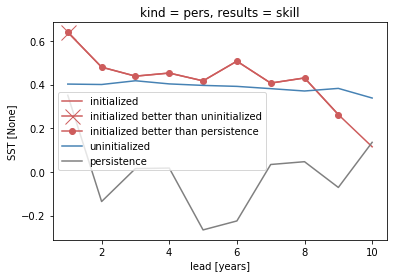

In [129]:
# create a plot by hand
bootstrapped_acc.sel(results='skill',kind='init').plot(c='indianred',label='initialized')
init_better_than_uninit.plot(c='indianred',marker='x',markersize=15,label='initialized better than uninitialized')
init_better_than_persistence.plot(c='indianred',marker='o',label='initialized better than persistence')
bootstrapped_acc.sel(results='skill',kind='uninit').plot(c='steelblue',label='uninitialized')
bootstrapped_acc.sel(results='skill',kind='pers').plot(c='gray',label='persistence')
plt.title(v)
plt.legend()

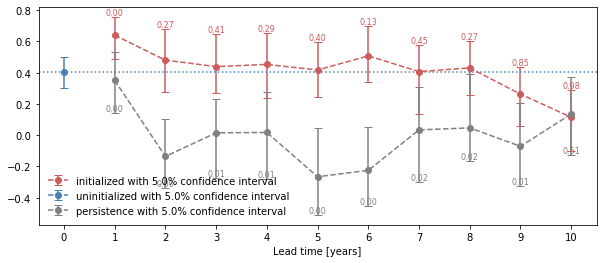

In [132]:
# use climpred convenience plotting function
from climpred.graphics import plot_bootstrapped_skill_over_leadyear
plot_bootstrapped_skill_over_leadyear(bootstrapped_acc,sig*100)

# field significance exmaple

In [3]:
import warnings
warnings.filterwarnings("ignore")

In [4]:
v='tos'
ds3d = load_dataset('MPI-PM-DP-3D')[v]
ds3d.lead.attrs['unit']='years'
control3d = load_dataset('MPI-control-3D')[v]

In [6]:
# ACC skill
acc3d = compute_perfect_model(ds3d, control3d, metric='pearson_r',comparison='m2e')

# ACC_p_value skill
acc_p_3d = compute_perfect_model(ds3d, control3d, metric='pearson_r_p_value',comparison='m2e')

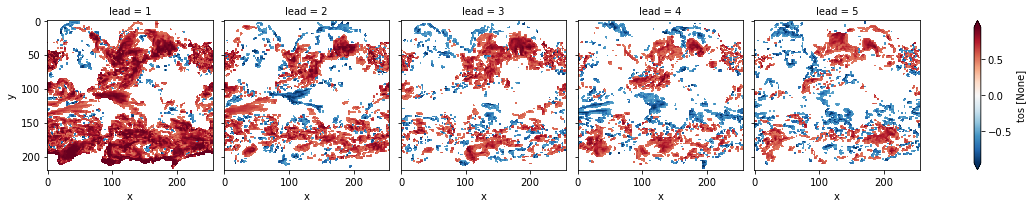

In [7]:
acc3d.where(acc_p_3d<=sig).plot(col='lead',robust=True,yincrease=False)

In [16]:
# apply FDR Benjamini-Hochberg
# relies on esmtools https://github.com/bradyrx/esmtools
from esmtools.testing import multipletests
_,acc_p_3d_fdr_corr = multipletests(acc_p_3d,method='fdr_bh',alpha=sig)

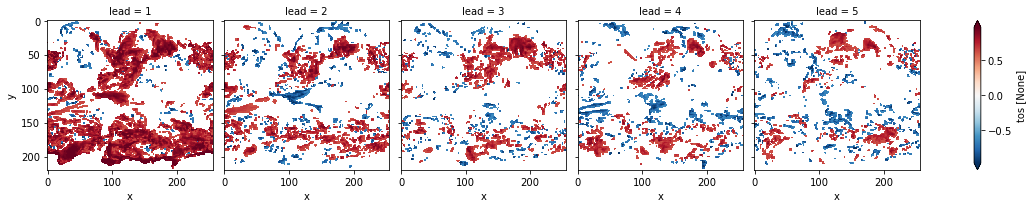

In [17]:
acc3d.where(acc_p_3d_fdr_corr<=sig).plot(col='lead',robust=True,yincrease=False)

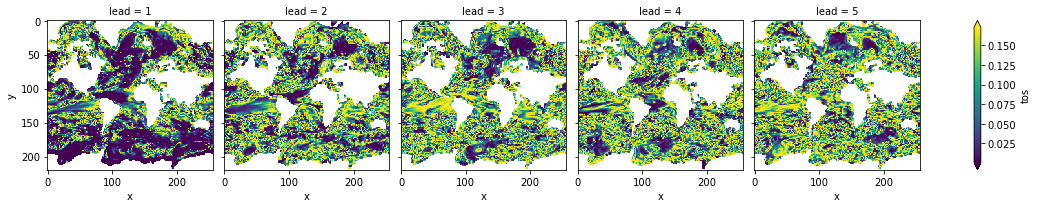

In [19]:
# difference due to FDR Benjamini-Hochberg
(acc_p_3d_fdr_corr - acc_p_3d).plot(col='lead',robust=True,yincrease=False)

In [23]:
bootstrapped_acc_3d = bootstrap_perfect_model(ds3d, control3d, metric='pearson_r',comparison='m2e', bootstrap=10)

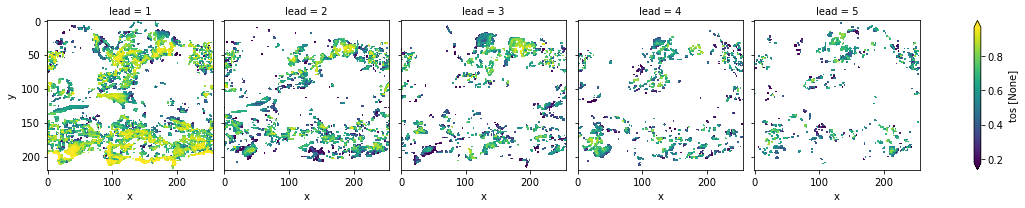

In [24]:
bootstrapped_acc_3d.sel(kind='init',results='skill').where(bootstrapped_acc_3d.sel(kind='uninit',results='p')<=sig).plot(col='lead',robust=True,yincrease=False)

In [26]:
# apply FDR Benjamini-Hochberg
_,bootstrapped_acc_p_3d_fdr_corr = multipletests(bootstrapped_acc_3d.sel(kind='uninit',results='p'),
                                                 method='fdr_bh',alpha=sig)

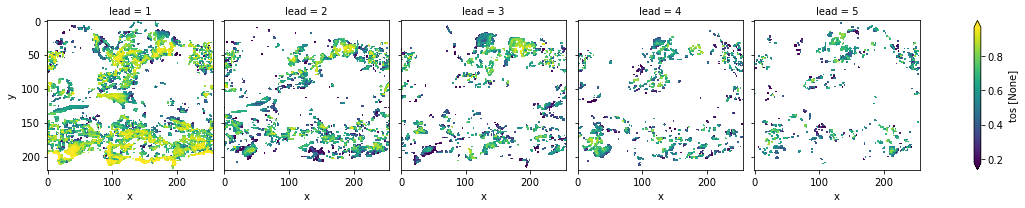

In [27]:
bootstrapped_acc_3d.sel(kind='init',results='skill').where(bootstrapped_acc_p_3d_fdr_corr<=sig).plot(col='lead',robust=True,yincrease=False)

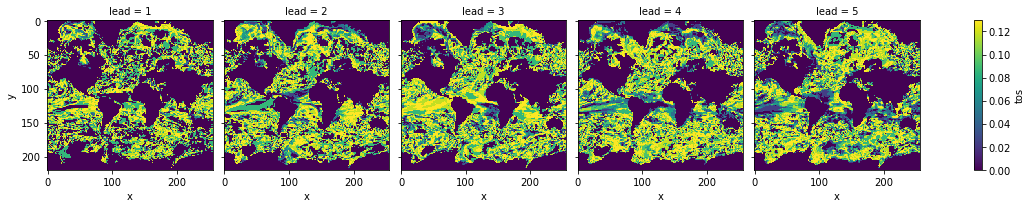

In [28]:
# difference due to FDR Benjamini-Hochberg
(bootstrapped_acc_p_3d_fdr_corr - bootstrapped_acc_3d.sel(kind='uninit',results='p')).plot(col='lead',robust=True,yincrease=False)